In [1]:
import os
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import clear_output
from utils.black_scholes import *
from utils.calibrator import *

plt.style.use("ggplot")

ivs_log_path = './ivs_log/{}'.format(datetime.date.today())
if not os.path.isdir(ivs_log_path):
    os.makedirs(ivs_log_path)

def find_strike(x):
    if x['symx'].__len__() > 5:
        return x['symx'][6:]
    else:
        return np.nan

def find_vega(x):
    return bs_vega(x["forward"], x["strike"], x["maturity"], x["market_imp_vol_prc"], x["r"], "c")

def Black(CP, F, X, sigma, T, r):
    d1 = (np.log(F/X) + (sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = F * np.exp(-1 * r * T) * norm.cdf(d1) - X * np.exp(-1 * r * T) * norm.cdf(d2)
    put_price =  X * np.exp(-1 * r * T) * norm.cdf(-1 * d2) - F * np.exp((-1 * r) * T) * norm.cdf(-1 * d1)
    value = call_price + CP * (put_price - call_price)
    return value

def newton_imp_vol(C0, CP, F, X, T, r, vol_est=0.25, n_iter=1000):
    for i in range(n_iter):
        d1 = (np.log(F/X) + (vol_est**2 / 2) * T) / (vol_est * np.sqrt(T))
        vega = F * np.exp(-1 * r * T) * norm.pdf(d1) * T**0.5
        vol_est = vol_est - (Black(CP, F, X, vol_est, T, r) - C0) / vega
    return vol_est


{'success': True, 'vr_': 0.2334289973490262, 'sr_': 0.4080103465963975, 'pc_': 2.296425294846197, 'cc_': 1.143210489310903}
{'success': True, 'vr_': 0.23279860783317521, 'sr_': 0.42938371297205197, 'pc_': 2.4096833358696546, 'cc_': 1.1162562749015539}


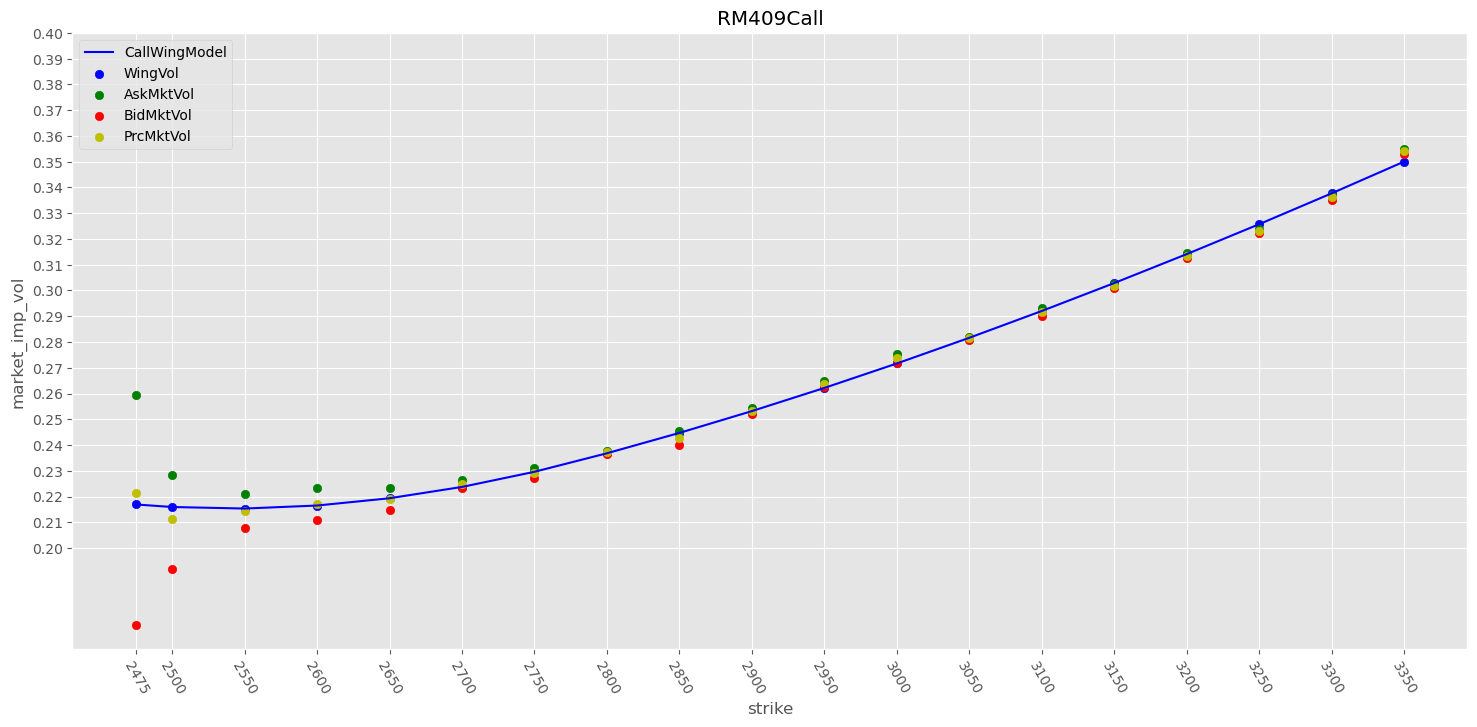

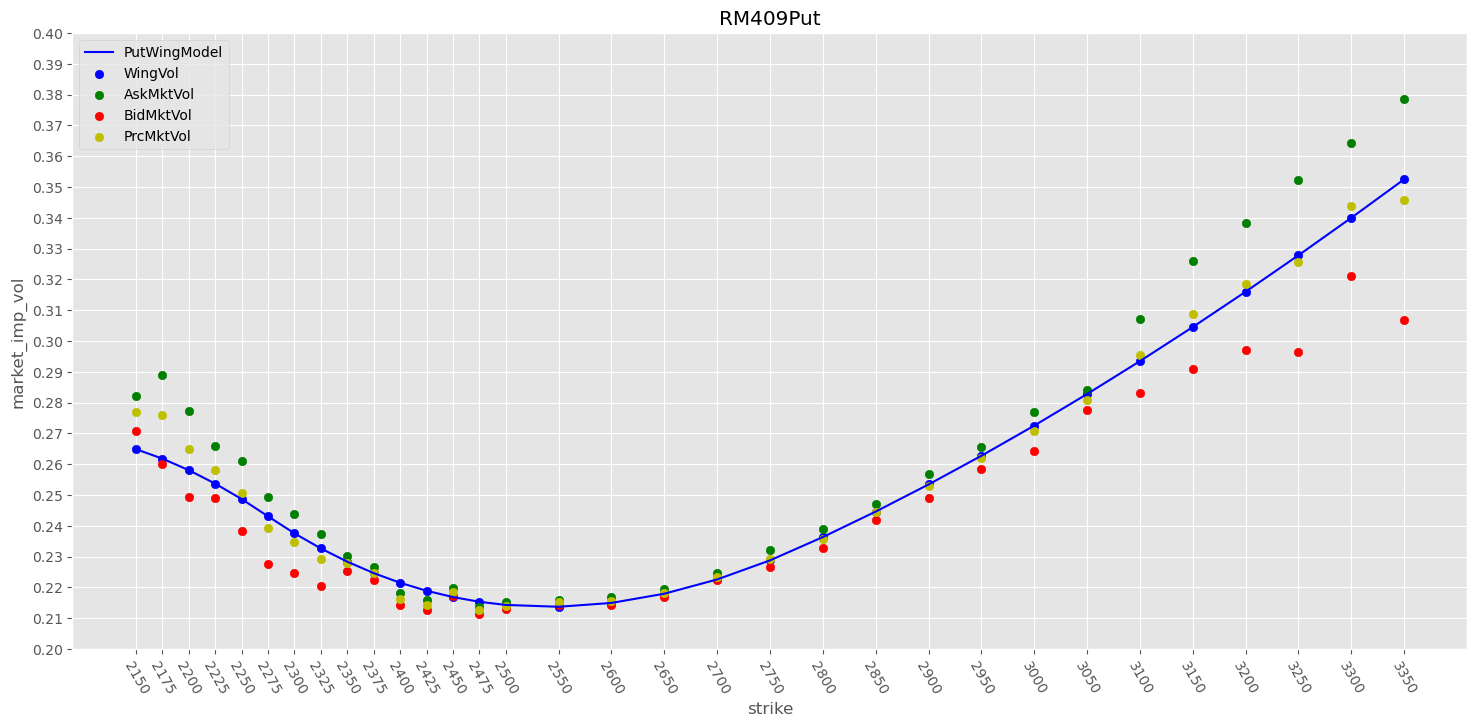

KeyboardInterrupt: 

In [2]:
while True:
    data = pd.read_csv("data_dev.csv", header=0)
    data.insert(data.shape[1], 'strike', data.apply(find_strike, axis=1))
    data.strike = data.strike.astype(float)
    data.insert(data.shape[1], 'cp', np.where(data['symx'].str.contains('C'), 0, 1))
    data.insert(data.shape[1], 'forward', data.iloc[0]['prc'])
    data.insert(data.shape[1], 'maturity', 69/365)
    data.insert(data.shape[1], 'r', 0.025)
    data.insert(data.shape[1], 'log_moneyness', value=np.log(data['strike'] / data['forward']))
    data = data.iloc[1:,:]
    data["market_imp_vol_prc"] = newton_imp_vol(data["prc"], data["cp"], data["forward"], data["strike"], data["maturity"], data["r"], 0.25, 500)
    data["market_imp_vol_ask"] = newton_imp_vol(data["askp1"], data["cp"], data["forward"], data["strike"], data["maturity"], data["r"], 0.25, 500)
    data["market_imp_vol_bid"] = newton_imp_vol(data["bidp1"], data["cp"], data["forward"], data["strike"], data["maturity"], data["r"], 0.25, 500)
    data['vega'] = bs_vega(data["forward"], data["strike"], data["maturity"], data["market_imp_vol_prc"], data["r"], "c") # type: ignore
    data = data.dropna()
    data_c = data[data['cp'] == 0]
    data_p = data[data['cp'] == 1]
    wing_model_params_list_input = [-0.2, 0.2, 0.5, 0.5]
    while True:
        moneyness_inputs_list = list(data_c['log_moneyness'])
        mkt_implied_vol_list = list(data_c['market_imp_vol_prc'])
        mkt_vega_list = list(data_c['vega'])
        final_res_c = wing_model_calibrator(wing_model_params_list_input,
                                        moneyness_inputs_list,
                                        mkt_implied_vol_list,
                                        mkt_vega_list,
                                        is_bound_limit=True)
        moneyness_inputs_list = list(data_p['log_moneyness'])
        mkt_implied_vol_list = list(data_p['market_imp_vol_prc'])
        mkt_vega_list = list(data_p['vega'])
        final_res_p = wing_model_calibrator(wing_model_params_list_input,
                                        moneyness_inputs_list,
                                        mkt_implied_vol_list,
                                        mkt_vega_list,
                                        is_bound_limit=True)
        if final_res_c['success'] and final_res_p['success']:
            break
    data_c.insert(data_c.shape[1], 'wing_model_vol', data_c['log_moneyness'].apply(lambda x: wing_model(x, final_res_c['vr_'], final_res_c['sr_'], final_res_c['pc_'], final_res_c['cc_'], -0.2, 0.2, 0.5, 0.5)))
    data_c.insert(data_c.shape[1], 'error', data_c['market_imp_vol_prc'] - data_c['wing_model_vol'])
    data_p.insert(data_p.shape[1], 'wing_model_vol', data_p['log_moneyness'].apply(lambda x: wing_model(x, final_res_p['vr_'], final_res_p['sr_'], final_res_p['pc_'], final_res_p['cc_'], -0.2, 0.2, 0.5, 0.5)))
    data_p.insert(data_p.shape[1], 'error', data_p['market_imp_vol_prc'] - data_p['wing_model_vol'])

    plt.figure(figsize=(18, 8))
    pl1 = data_c.sort_values(by="strike")
    plt.plot(pl1["strike"], pl1["wing_model_vol"], c='b')
    plt.scatter(pl1["strike"], pl1["wing_model_vol"], c='b')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_ask"], c='g')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_bid"], c='r')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_prc"], c='y')
    plt.xlabel("strike")
    plt.ylabel("market_imp_vol")
    plt.yticks(np.arange(0.20, 0.41, 0.01))
    plt.xticks(pl1["strike"], rotation=-60)
    plt.title('RM409Call')
    plt.legend(['CallWingModel', 'WingVol', 'AskMktVol', 'BidMktVol', 'PrcMktVol'])
    plt.savefig("./{}/RM409Call_{}.png".format(ivs_log_path, time.strftime("%H_%M_%S")), bbox_inches='tight')
    plt.savefig("./RM409Call.png", bbox_inches='tight')

    plt.figure(figsize=(18, 8))
    pl1 = data_p.sort_values(by="strike")
    plt.plot(pl1["strike"], pl1["wing_model_vol"], c='b')
    plt.scatter(pl1["strike"], pl1["wing_model_vol"], c='b')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_ask"], c='g')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_bid"], c='r')
    plt.scatter(pl1["strike"], pl1["market_imp_vol_prc"], c='y')
    plt.xlabel("strike")
    plt.ylabel("market_imp_vol")
    plt.yticks(np.arange(0.20, 0.41, 0.01))
    plt.xticks(pl1["strike"], rotation=-60)
    plt.title('RM409Put')
    plt.legend(['PutWingModel', 'WingVol', 'AskMktVol', 'BidMktVol', 'PrcMktVol'])
    plt.savefig("./{}/RM409Put_{}.png".format(ivs_log_path, time.strftime("%H_%M_%S")), bbox_inches='tight')
    plt.savefig("./RM409Put.png", bbox_inches='tight')

    plt.show()
    time.sleep(10)
    clear_output()


In [ ]:
# while True:
#     data = pd.read_csv("data_dev.csv", header=0)
#     data.insert(data.shape[1], 'strike', data.apply(find_strike, axis=1))
#     data.strike = data.strike.astype(float)
#     data.insert(data.shape[1], 'cp', np.where(data['symx'].str.contains('C'), 0, 1))
#     data.insert(data.shape[1], 'forward', data.iloc[0]['prc'])
#     data.insert(data.shape[1], 'maturity', 69/365)
#     data.insert(data.shape[1], 'r', 0.025)
#     data.insert(data.shape[1], 'log_moneyness', value=np.log(data['strike'] / data['forward']))
#     data = data.iloc[1:,:]
#     data["market_imp_vol"] = newton_imp_vol(C0 = data["prc"],
#                                             CP = data["cp"],
#                                             F = data["forward"],
#                                             X = data["strike"],
#                                             T = data["maturity"],
#                                             r = data["r"],
#                                             vol_est = 0.25,
#                                             n_iter = 500)
#     data.insert(data.shape[1], 'vega', data.apply(find_vega, axis=1))
#     data = data.dropna()
#     data_c = data[data['cp'] == 0]
#     data_p = data[data['cp'] == 1]
#     wing_model_params_list_input = [-0.2, 0.2, 0.5, 0.5]
#     while True:
#         moneyness_inputs_list = list(data_c['log_moneyness'])
#         mkt_implied_vol_list = list(data_c['market_imp_vol'])
#         mkt_vega_list = list(data_c['vega'])
#         final_res_c = wing_model_calibrator(wing_model_params_list_input,
#                                         moneyness_inputs_list,
#                                         mkt_implied_vol_list,
#                                         mkt_vega_list,
#                                         is_bound_limit=True)
#         moneyness_inputs_list = list(data_p['log_moneyness'])
#         mkt_implied_vol_list = list(data_p['market_imp_vol'])
#         mkt_vega_list = list(data_p['vega'])
#         final_res_p = wing_model_calibrator(wing_model_params_list_input,
#                                         moneyness_inputs_list,
#                                         mkt_implied_vol_list,
#                                         mkt_vega_list,
#                                         is_bound_limit=True)
#         if final_res_c['success'] and final_res_p['success']:
#             break
#     data_c.insert(data_c.shape[1], 'wing_model_vol', data_c['log_moneyness'].apply(lambda x: wing_model(x, final_res_c['vr_'], final_res_c['sr_'], final_res_c['pc_'], final_res_c['cc_'], -0.2, 0.2, 0.5, 0.5)))
#     data_c.insert(data_c.shape[1], 'error', data_c['market_imp_vol'] - data_c['wing_model_vol'])
#     data_p.insert(data_p.shape[1], 'wing_model_vol', data_p['log_moneyness'].apply(lambda x: wing_model(x, final_res_p['vr_'], final_res_p['sr_'], final_res_p['pc_'], final_res_p['cc_'], -0.2, 0.2, 0.5, 0.5)))
#     data_p.insert(data_p.shape[1], 'error', data_p['market_imp_vol'] - data_p['wing_model_vol'])
#     plt.figure(figsize=(18, 10))
#     pl1 = data_c.sort_values(by="strike")
#     plt.plot(pl1["strike"], pl1["wing_model_vol"], c='b')
#     plt.scatter(pl1["strike"], pl1["market_imp_vol"], c='b')
#     plt.scatter(pl1["strike"], pl1["wing_model_vol"], c='r')
#     pl1 = data_p.sort_values(by="strike")
#     plt.plot(pl1["strike"], pl1["wing_model_vol"], c='g')
#     plt.scatter(pl1["strike"], pl1["market_imp_vol"], c='g')
#     plt.scatter(pl1["strike"], pl1["wing_model_vol"], c='r')
#     plt.xlabel("strike")
#     plt.ylabel("market_imp_vol")
#     plt.yticks(np.arange(0.20, 0.41, 0.01))
#     plt.xticks(pl1["strike"], rotation=-60)
#     plt.title('RM409')
#     plt.legend(['Call', 'MktVol', 'WingVol', 'Put', 'MktVol', 'WingVol'])
#     plt.show()
#     time.sleep(5)
#     clear_output()
